# Mapa interactivo arbolado urbano Las Condes

V1. 04-12-2024.  
El proyecto consiste en un análisis descriptivo del arbolado urbano (calles y avenidas) de la comuna de Las Condes, Región Metropolitana, Chile, con la generación de un mapa interactivo.  
Los datos provienen de un archivo _shapefile_ obtenido del geoportal disponible en https://arcgismlc.lascondes.cl/portal/apps/mapviewer/index.html?webmap=9cd26fb71ea1448290450a9889467bc8.  
El _shapefile_ corresponde a la ubicación en coordenadas UTM Datum WGS84 huso 19S, de cada árbol en los ejes viales comuna, cada registro cuenta con datos descriptivos del ejemplar, como altura, diametro, número de ramas y estado general, entre otros. Sin embargo, no cuenta con la dirección del árbol.  
Se hizo una `Geocodificación` para agregar la dirección, en primera instancia se probó con la librería `Geopy`, que utiliza varios proveedores como OSM, GSM o BING, sin embargo, tiene un límite de 1000 request por día, por lo cual fue insuficiente para el proyecto. Por esta razón, se decidió emplear, la API de GoogleMaps dispible en GCP que cuenta con 40.000 request mensuales + 300 créditos para uso de cuentas nuevas, esto permite un total de 100.000 request mnesuales.  
El proceso tomó alrededor de 5 horas y 1927 árboles no pudieron ser geocodificados (dirección no disponible).

Información descriptiva encontrada:
* Total de árboles en calles y avenidas: 90983
* Top 5 especies:
  1. *Liquidambar styraciflua*, 19%
  2. *Acer negundo*, 8%
  3. *Liriodendron tulipifera*, 7%
  4. *Jacaranda mimosifolia*, 6%
  5. *Melia azedarach*, 5%
* Existen 150 árboles con más de 20 metros de altura  

* Top 5 calles con más árboles
  |Calle| árboles | más frecuente |
  |-----|---------|---------------|
  |Paul Harris| 1370 | Liquidámbar (197)|
  |Presidente Riesco|	1171|Platano Oriental	(356)|
  |Avenida Apoquindo|	1136|	Tulipero	(667)|
  |San Carlos de Apoquindo |1018|Liquidámbar	(457)|
  |Avenida Cristóbal Colón|	887|	Platano Oriental	(452)|  


Próximo paso utilizar la API de google que tiene 40.000 request por día https://notebook.community/gboeing/urban-data-science/18-Geocoding-and-Geolocation/geocoding

## Imports & Loads

In [23]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import time

# adjust column width
pd.set_option('display.max_columns', 110)

# settings
import warnings
warnings.filterwarnings('ignore')

# Mapas interactivos
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [2]:
catastro = gpd.read_file('./data/catastro_LC.shp')
unidad_vecinal = gpd.read_file('./data/UV_LC.shp')

## Análisis exploratorio de datos

In [3]:
# revisión de CRS del shapefile catastro
print(catastro.crs)
print(unidad_vecinal.crs)

EPSG:32719
EPSG:4326


In [4]:
catastro.head()

,OBJECTID,id,latitud,longitud,coor_norte,coor_este,especie,sub_unidad,ubicacion,fecha_de_p,tipo,edad_relat,dap,altura_ram,número_de,altura,arquitectu,estado_est,inclinaci,orientaci,cables_aé,presencia_,estado_fit,estado_gen,observacio,nombre_cie,fecha_crea,geometry
0,1,547,-33.392736,-70.515947,6.304146e+10,3.590107e+09,Quillay,C-25,Calle,None,Arbol,Joven,Menor a 10 cm,2.0,1,3.0,Balanceado / Equilibrada,Balanceado,Leve (< a 14°),Costado,No,No,Bueno,Bueno,None,Quillaja saponaria Molina,2019-05-31,POINT (359010.734 6304146.229)
1,2,581,-33.398736,-70.506818,6.303493e+10,3.598695e+09,Quillay,C-25,Avenida,None,Arbol,Joven,Menor a 10 cm,1.2,1,2.5,Balanceado / Equilibrada,Balanceado,Sin inclinación,Sin Orientación,No,Si,Bueno,Bueno,None,Quillaja saponaria Molina,2019-05-27,POINT (359869.49 6303493.319)
2,3,653,-33.398111,-70.513088,6.303554e+10,3.592853e+09,Acer Japonico,C-25,Calle,None,N/D,Joven,Menor a 10 cm,0.0,0,2.5,N/D,N/D,N/D,N/D,No,No,N/D,Bueno,None,Acer palmatum,2019-05-28,POINT (359285.32 6303554.149)
3,4,688,-33.398051,-70.513005,6.303561e+10,3.592930e+09,Acacia de Japón,C-25,Calle,None,Arbol,Joven,Menor a 10 cm,1.2,1,3.0,Balanceado / Equilibrada,Balanceado,Sin inclinación,Sin Orientación,No,No,N/D,Muerto,None,Sophora japonica L.,2020-01-30,POINT (359292.988 6303560.888)
4,5,733,-33.392572,-70.515875,6.304164e+10,3.590171e+09,Quillay,C-25,Calle,None,Arbol,Joven,Menor a 10 cm,0.8,1,3.0,Balanceado / Equilibrada,Balanceado,Sin inclinación,Sin Orientación,No,No,Bueno,Bueno,None,Quillaja saponaria Molina,2019-05-31,POINT (359017.131 6304164.482)


In [5]:
catastro.especie.value_counts().sum()

np.int64(90983)

In [6]:
# Porcentaje de especies
catastro.nombre_cie.value_counts().to_frame().T/catastro['nombre_cie'].count()*100

nombre_cie,Liquidambar styraciflua L.,Acer negundo,Liriodendron tulipifera,Jacaranda mimosifolia,Melia azedarach L.,Quillaja saponaria Molina,Prunus cerasifera Ehrh.,Platanus orientalis L,Fraxinus excelsior L.,Prunus domestica,Ulmus americana,Robinia pseudoacacia,Tilia sp.,Schinus molle,Celtis australis L,Ligustrum lucidum,Acer pseudoplatanus L.,Grevillea robusta,Lagerstroemia indica L.,Acer palmatum,Catalpa bignonioidesWalt.,Sophora japonica L.,Aesculus hippocastanum,Quercus falcata,Phoenix canariensis,Cryptocarya alba,Ailanthus altissima,Prunus cerasifera Ehrh,Fraxinus ornus L.,Ginkgo biloba L.,Jacaranda momosifolia,Styphnolobium japonicum,Acacia caven (Molina) Molina,Washingtonia robusta,Quercus robur L.,Brachychiton populneus,Maytenus boaria,Acacia melanoxylon,Cercis siliquastrum,Crinodendron patagua,Cupressus,Magnolia grandiflora,Populus nigra,Laurus nobilis,Manihot esculenta,Platanus acerifolia,Eriobotrya japonica,Morus nigra,Trachycarpus fortunei,Eucalyptus globulus,Melia azadarach L.,Prunus dulcis,Acacia dealbata,Erithrina umbrosa,Gleditsia triacanthos L.,...,Crataegus monogyna,Ficus benjamina,Citrus paradisi,Arbutus unedo L.,Acacia saligna,Tipuana tipu,Cersis siliquastrum,Pyracantha coccinea,Eleagnus pungens,Eucalyptus gunnii,Albizia Julibrissin,Acer Palmatum,Persea amerciana Miller,Syringa vulgaris,Populus deltoides,Acer platanoide,Salix matsudana tortuosa,Ligustrum japonicum,Terminalia catappa,Pinus canariensis,Taxus baccata,Caesalpinia gilliesii,Acacia capensis,Prunus cerrulata,Prunus ceracifera,Rhamnus spp,Robinia hispidia,Viburnum opulus,Prunus cerasifera,Picea pungens,Gleditsia tricanthos L.,Crataegus oxyacantha,Bougainvillea sp.,Prunus avium,Ricinus communis,Malus baccata var.purpurea,Thujopsis dolabrata,Nandina domestica,Brachychiton Discolor,Melaleuca sp.,Leucaena sp,Hibiscus syriacus,Colliguaja odorifera,Acacia cultriformis,Schinus polygamus,Persea lingue,Thuja plicata,Cestrum parqui,Thuja sp,Zelkova serrata,Cupressus sempervirens,Tamarindus indica,Amenlanchier ovalis,Araucaria columnaris,Populos Alba
count,19.563292,7.988746,7.174963,6.179593,5.978949,5.924025,4.380528,4.090211,3.858182,2.487306,2.359522,2.337103,1.679127,1.634291,1.545739,1.539013,1.475121,1.087285,0.910181,0.764463,0.758858,0.72411,0.664701,0.622107,0.55261,0.533555,0.487597,0.485355,0.47863,0.436035,0.420342,0.409133,0.408012,0.40465,0.377748,0.317218,0.30713,0.284712,0.28247,0.275745,0.266777,0.239875,0.219699,0.204006,0.200643,0.193918,0.18383,0.182709,0.180467,0.177104,0.168137,0.161411,0.156928,0.154686,0.149081,...,0.004484,0.004484,0.004484,0.004484,0.004484,0.004484,0.004484,0.004484,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.003363,0.002242,0.002242,0.002242,0.002242,0.002242,0.002242,0.002242,0.002242,0.002242,0.002242,0.002242,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121,0.001121


In [7]:
catastro.groupby('especie')['altura'].describe().sort_values('mean', ascending=False).T

especie,Álamo Carolina,Cedro del Líbano,Casuarina,Alamo Negro,Eucalipto azul,Cedro del Himalaya,Pino Insigne,Eucalipto Brillante,Platano Oriental Var. Hispanica,Secuoya roja,Ceibo,Cedro del Atlas,Olmo,Grevillea,Platano Oriental Var. Acerifolia,Acacio tres espinas,Ciprés de California,Alamo Blanco,Encina,Pino canario,Platano Oriental,Abeto,Acacio Blanco,Eucalipto de Gunn,Leucaena,Roble Europeo,Aromo australiano,Ombú,Ailanto,Pino Oregón,Paulonia,Taxodium distichum,Melia,Sauce Llorón,Roble Rojo Americano,Acacia Saligna,Mezquite dulce,Acacia Visco,Liquidámbar,Sofora,Acer Negundo,Fresno Europeo,Aromo Frances,Acer trifolium,Catalpa,Acacia de Japón,Roble de Turquía,Palo Borracho,Arce Real,Belloto del Sur,Tejo,Palto,Sterculea rosada,Ciprés,Junípero,...,Abeto Glauca,Nispero,Laurel de Flor,Boldo,Peral,Acer sp,Araucaria Chilena,Higuera,Pitosporo Tobira,Almendro de la India,Aligustrón,Aromillo,Quebracho,Gomero,Yucca sp,Acer Japonico,Litre,Molle,Granado,Huingán,Acacia cultriformis,Cerezo péndulo,Rhamnus,Manzano Silvestre,Durazno,Membrillo,Cotoneaster,Aligustre,Limon,Arrayán,Crespón,Melaleuca,Copo de Nieve,Palma Chilena,Ponciano,Pelu,N/D,Colliguay,Higuerilla,Nandina,Lila,Lingue,Ficus benjamina,Espinon de Fugo,Acacio,Eleagno,Pino Sp.,Ligustro sp,Ciruelo Verde,Araucaria Columnar,Acacio Rosado,Crataegus,Hibiscus,Plantera Vacia,Palqui
count,3.0,71.000000,64.000000,196.000000,160.000000,51.000000,31.000000,20.000000,34.000000,87.000000,138.000000,7.000000,2105.000000,1034.000000,173.000000,135.000000,10.000000,80.000000,53.000000,3.000000,3649.000000,39.000000,2122.000000,3.000000,1.0,343.000000,266.000000,25.00000,435.000000,64.000000,98.000000,12.000000,5484.000000,14.000000,7.000000,58.000000,6.000000,14.000000,17453.000000,365.000000,7233.000000,3442.000000,145.000000,36.000000,677.000000,646.000000,11.000000,10.000000,3.000000,11.000000,2.0,50.000000,13.000000,238.000000,26.000000,...,7.000000,164.000000,9.000000,6.000000,10.000000,5.00000,23.000000,11.000000,95.000000,3.000000,3.000000,3.000000,10.00000,13.000000,179.000000,685.000000,15.000000,15.000000,66.000000,1.0,1.0,1.0,2.000000,1.0,64.000000,8.000000,9.000000,11.000000,72.000000,20.000000,831.000000,1.0,2.000000,29.000000,2.000000,6.000000,379.000000,1.0,1.0,1.0,3.000000,1.0,4.000000,4.000000,18.000000,3.000000,3.000000,15.000000,4.0,1.0,2.0,1.0,1.0,10.0,1.0
mean,15.0,14.988732,13.734375,13.729592,12.770625,12.662745,12.290323,12.100000,11.867647,11.821839,11.641304,11.571429,11.466128,11.302515,11.219653,11.203704,10.950000,10.737500,10.683019,10.666667,10.565936,10.500000,10.405561,10.333333,10.0,9.872886,9.851128,9.84000,9.676322,9.585938,9.488776,9.400000,9.310394,9.285714,9.285714,9.206897,9.166667,9.142857,9.096597,8.934247,8.919840,8.864265,8.671034,8.666667,8.604136,8.585294,8.454545,8.400000,8.333333,8.227273,8.0,7.964000,7.907692,7.821429,7.730769,...,3.771429,3.709146,3.666667,3.650000,3.630000,3.60000,3.478261,3.409091,3.363158,3.333333,3.333333,3.333333,3.24000,3.230769,3.191620,3.140876,3.133333,3.033333,3.006061,3.0,3.0,3.0,3.000000,3.0,2.940625,2.875000,2.844444,2.772727,2.701389,2.700000,2.555716,2.5,2.500000,2.337931,2.300000,2.166667,2.018997,2.0,2.0,2.0,1.833333,1.8,1.750000,1.500000,1.333333,1.000000,0.666667,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,3.617874,2.863244,4.487972,3.988231,4.271064,6.149220,3.851179,4.782083,5.182875,3.772252,3.309438,3.892172,3.682739,2.042646,4.318606,3.320392,4.993119,4.481832,1.527525,4.505383,5.620685,3.730051,2.886751,NaN,4.333184,4.269799,3.46025,4.330975,4.311810,4.442992,4.827196,3.025453,4.681035,4.070802,3.099285,0.983192,2.023217,3.720568,2.834541,3.067096,3.115214,3.842578,3.531491,3.150131,2.685618,2.919371,3.025815,4.932883,3.669902,0.0,3.744588,3.542942,4.458454,3.876160,...,3.697168,2.012501,0.866025,1.983683,2.397244,2.50998,4.424719,1.763210,1.707247,1.755942,1.527525,2.886751,1.91729,2.781002,1.821589,1.802368,1.922300,2.021904,1.354750,NaN,NaN,NaN,4.242641,NaN,1.672724,2.356602,1.297219,0.606780,2.008187,1.94

In [8]:
# Transformar a WGS84
catastro = catastro.to_crs(epsg=4326)
unidad_vecinal = unidad_vecinal.to_crs(epsg=4326)

In [9]:
arb_20m = catastro[catastro['altura'] >= 20]
#print(arb_20m.count())
arb_20m.groupby('especie')['altura'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
especie,,,,,,,,
Abeto,4.0,23.750000,2.500000,20.0,23.75,25.0,25.00,25.0
Jacaranda,2.0,23.000000,1.414214,22.0,22.50,23.0,23.50,24.0
Almendro,1.0,22.000000,NaN,22.0,22.00,22.0,22.00,22.0
Alamo Blanco,1.0,22.000000,NaN,22.0,22.00,22.0,22.00,22.0
Paulonia,2.0,22.000000,2.828427,20.0,21.00,22.0,23.00,24.0
Alamo Negro,11.0,21.727273,2.240130,20.0,20.00,20.0,23.50,25.0
Quillay,3.0,21.633333,0.550757,21.0,21.45,21.9,21.95,22.0
Ceibo,3.0,21.333333,2.309401,20.0,20.00,20.0,22.00,24.0
Tulipero,3.0,21.333333,2.309401,20.0,20.00,20.0,22.00,24.0


<Axes: >

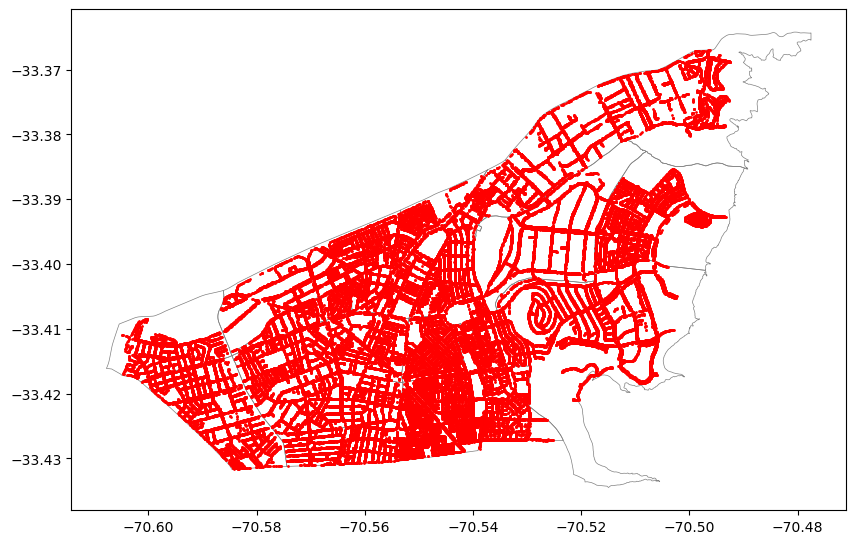

In [10]:
ax = unidad_vecinal.plot(figsize=(10, 10), edgecolor='gray', facecolor='none', linewidth=0.5)
catastro.plot(ax=ax, color='red', markersize=1)


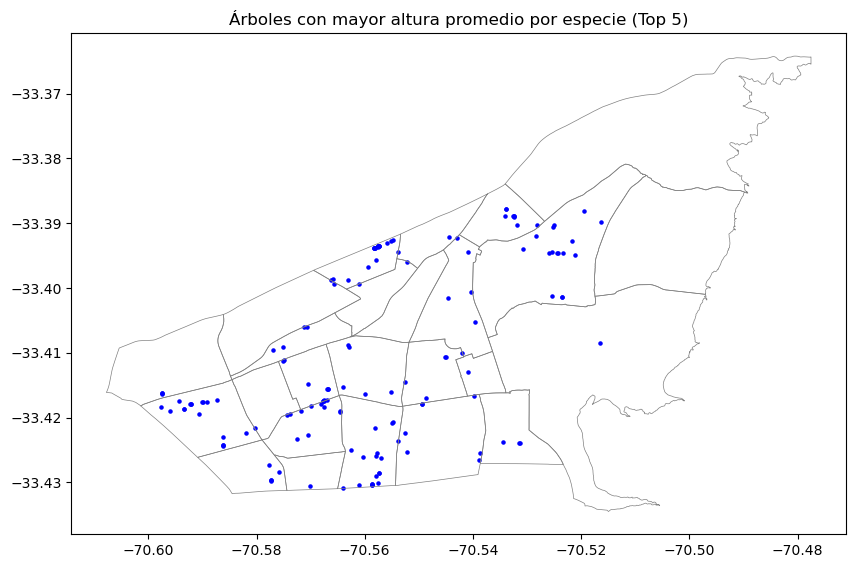

In [11]:
# Obtener las estadísticas descriptivas por especie
stats = arb_20m.groupby('especie')['altura'].describe()

# Ordenar por la altura media (mean) de forma descendente
stats_sorted = stats.sort_values('mean', ascending=False)

# Seleccionar las especies que deseas filtrar (por ejemplo, las 5 con mayor altura promedio)
top_species = stats_sorted.head(5).index

# Filtrar el GeoDataFrame para incluir solo esas especies
arb_filtered = arb_20m[arb_20m['especie'].isin(top_species)]

# Visualizar el mapa con el GeoDataFrame filtrado
fig, ax = plt.subplots(figsize=(10, 10))
arb_20m.plot(ax=ax, color='blue', markersize=5)
unidad_vecinal.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=0.5)
plt.title("Árboles con mayor altura promedio por especie (Top 5)")
plt.show()


In [12]:
# Uniformizar los nombres de las columnas de las unidades vecinales
unidad_vecinal['vecinal'] = unidad_vecinal['vecinal'].replace({
                                        'C-1':'C-01',
                                        'C-2':'C-02',
                                        'C-3':'C-03',
                                        'C-4':'C-04',
                                        'C-5':'C-05',
                                        'C-6':'C-06',
                                        'C-7':'C-07',
                                        'C-8':'C-08',
                                        'C-9':'C-09'
                                       })

In [13]:
unidad_vecinal

,fid_,u_vecinal,vecinal,macro_t,mt_num,id,SHAPE__Len,SHAPE__Are,geometry
0,0,4.0,C-04,MT-03,3.0,1,0.034701,0.000057,"POLYGON Z ((-70.56507 -33.43096 0, -70.56613 -..."
1,0,3.0,C-03,MT-03,3.0,2,0.040242,0.000087,"POLYGON Z ((-70.5767 -33.42578 0, -70.57615 -3..."
2,0,5.0,C-05,MT-03,3.0,3,0.041802,0.000097,"POLYGON Z ((-70.56357 -33.42521 0, -70.56389 -..."
3,0,14.0,C-14,MT-04,4.0,4,0.049879,0.000139,"POLYGON Z ((-70.553 -33.41823 0, -70.55297 -33..."
4,0,15.0,C-15,MT-04,4.0,5,0.054634,0.000191,"POLYGON Z ((-70.53865 -33.42706 0, -70.5388 -3..."
5,0,23.0,C-23,MT-06,6.0,6,0.050719,0.000113,"POLYGON Z ((-70.5233 -33.42722 0, -70.52509 -3..."
6,0,2.0,C-02,MT-02,2.0,7,0.053693,0.000149,"POLYGON Z ((-70.57898 -33.42343 0, -70.57941 -..."
7,0,6.0,C-06,MT-03,3.0,8,0.037984,0.000083,"POLYGON Z ((-70.57184 -33.41875 0, -70.57264 -..."
8,0,22.0,C-22,MT-06,6.0,9,0.027886,0.000043,"POLYGON Z ((-70.53389 -33.41617 0, -70.53406 -..."
9,0,7.0,C-07,MT-03,3.0,10,0.033966,0.000071,"POLYGON Z ((-70.56473 -33.41659 0, -70.56494 -..."


In [14]:
uv = unidad_vecinal[['vecinal', 'geometry']].set_index('vecinal')
uv

,geometry
vecinal,
C-04,"POLYGON Z ((-70.56507 -33.43096 0, -70.56613 -..."
C-03,"POLYGON Z ((-70.5767 -33.42578 0, -70.57615 -3..."
C-05,"POLYGON Z ((-70.56357 -33.42521 0, -70.56389 -..."
C-14,"POLYGON Z ((-70.553 -33.41823 0, -70.55297 -33..."
C-15,"POLYGON Z ((-70.53865 -33.42706 0, -70.5388 -3..."
C-23,"POLYGON Z ((-70.5233 -33.42722 0, -70.52509 -3..."
C-02,"POLYGON Z ((-70.57898 -33.42343 0, -70.57941 -..."
C-06,"POLYGON Z ((-70.57184 -33.41875 0, -70.57264 -..."
C-22,"POLYGON Z ((-70.53389 -33.41617 0, -70.53406 -..."


In [15]:
# Number of trees in each uv
catastro.rename(columns={'sub_unidad':'vecinal'}, inplace=True)
plot_dict = catastro.vecinal.value_counts()
plot_dict.head()

vecinal
C-24    9001
C-15    8116
C-20    7968
C-25    7506
C-21    4926
Name: count, dtype: int64

In [16]:
# N árboles en cada UV
plot_dict

vecinal
C-24    9001
C-15    8116
C-20    7968
C-25    7506
C-21    4926
C-17    4612
C-14    4231
C-16    3927
C-02    3663
C-13    3595
C-23    3415
C-01    2849
C-09    2815
C-11    2470
C-05    2463
C-10    2431
C-07    2222
C-12    2157
C-03    2128
C-06    2064
C-08    2018
C-19    1886
C-04    1642
C-18    1515
C-22    1363
Name: count, dtype: int64

In [17]:
# total árboles de 20 metros o más
arb_20m.shape[0]

150

In [18]:
# N especies de 20 metros o más
arb_20m.especie.value_counts().to_frame()

,count
especie,
Liquidámbar,31
Platano Oriental,20
Grevillea,13
Alamo Negro,11
Cedro del Líbano,8
Olmo,8
Eucalipto azul,7
Acacio Blanco,5
Fresno Europeo,4


## Geocoding para integrar las direcciones usando las coordenadas

Utilizamos Geopy para hacer geocodificación inversa de los árboles de 20 o más metros de altura

In [19]:
# Geocodificación de direcciones
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geo_map_tree")

In [20]:
row = arb_20m.iloc[0]  # Seleccionar la primera fila como ejemplo
location = geolocator.reverse((row.geometry.y, row.geometry.x))
print(location.address)


2486, Camino Otoñal, La Foresta, Las Condes, Provincia de Santiago, Región Metropolitana de Santiago, 7600427, Chile


In [21]:
direcciones = []
calles = []
numeros = []
for idx, row in arb_20m.iterrows():
    location = geolocator.reverse((row.geometry.y, row.geometry.x))
    #calle = location.address.split(",")[1] a veces falla
    calle = location.raw['address'].get('road', 'Calle no disponible')
    numero = location.raw['address'].get('house_number', 'Número no disponible')
    direcciones.append(location.address)
    calles.append(calle)
    numeros.append(numero)
    
    time.sleep(1)

In [24]:
arb_20m['calle'] = calles
arb_20m['numero'] = numeros
arb_20m['direccion'] = direcciones

In [25]:
arb_20m.calle.value_counts().to_frame().head(10)

,count
calle,
Avenida Presidente Kennedy,16
Avenida Cristóbal Colón,12
Campanario,6
Vichato,6
Callao,5
Camino Las Flores,5
Camino de las Lavandulas,4
Camino El Alba,4
Alcántara,4


### Alternativa usando la API de Google Maps  
Geopy con el geocodificador de Nominatim tiene un límite de 1000 request por día, lo que es insuficiente para el total de árboles (90983), por lo tanto se hace una prueba con la API de **GoogleMaps**, para posteriormente codificar todo el geodataframe del catastro

In [26]:
import json

# Leer el archivo JSON
with open("config.json") as f:
    config = json.load(f)

api_key = config["API_KEY"]

In [27]:
# Prueba uso API de google maps
import googlemaps

# Tu clave de API
gmaps = googlemaps.Client(key=api_key)

# Dirección a geocodificar
address = "1600 Pennsylvania Ave NW, Washington, DC"

# Realizar geocodificación
geocode_result = gmaps.geocode(address)
print(geocode_result)


[{'address_components': [{'long_name': '1600', 'short_name': '1600', 'types': ['street_number']}, {'long_name': 'Pennsylvania Avenue Northwest', 'short_name': 'Pennsylvania Avenue NW', 'types': ['route']}, {'long_name': 'Northwest Washington', 'short_name': 'Northwest Washington', 'types': ['neighborhood', 'political']}, {'long_name': 'Washington', 'short_name': 'Washington', 'types': ['locality', 'political']}, {'long_name': 'District of Columbia', 'short_name': 'DC', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '20500', 'short_name': '20500', 'types': ['postal_code']}, {'long_name': '0005', 'short_name': '0005', 'types': ['postal_code_suffix']}], 'formatted_address': '1600 Pennsylvania Avenue NW, Washington, DC 20500, USA', 'geometry': {'location': {'lat': 38.8948949, 'lng': -77.0371581}, 'location_type': 'ROOFTOP', 'viewport': {'northeast': {'lat': 38.89636408029151, 'lng'

In [28]:
# inverse geocoding
row = arb_20m.iloc[0]  # Seleccionar la primera fila como ejemplo
coordinates = (row.geometry.y, row.geometry.x)  # Asegurarse de usar una tupla
loc = gmaps.reverse_geocode(coordinates)
print(loc)

[{'address_components': [{'long_name': '2490', 'short_name': '2490', 'types': ['street_number']}, {'long_name': 'Camino Otoñal', 'short_name': 'Cam. Otoñal', 'types': ['route']}, {'long_name': 'Las Condes', 'short_name': 'Las Condes', 'types': ['locality', 'political']}, {'long_name': 'Las Condes', 'short_name': 'Las Condes', 'types': ['administrative_area_level_3', 'political']}, {'long_name': 'Santiago', 'short_name': 'Santiago', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'Región Metropolitana', 'short_name': 'Región Metropolitana', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Chile', 'short_name': 'CL', 'types': ['country', 'political']}], 'formatted_address': 'Cam. Otoñal 2490, Las Condes, Región Metropolitana, Chile', 'geometry': {'bounds': {'northeast': {'lat': -33.4082816, 'lng': -70.51624939999999}, 'southwest': {'lat': -33.4085207, 'lng': -70.5165791}}, 'location': {'lat': -33.40840660000001, 'lng': -70.5164102}, 'location_t

In [ ]:
# 
direcciones = []
calles = []
numeros = []

# Iterar sobre el GeoDataFrame
for idx, row in catastro.iterrows():
    try:
        # Consulta de geocodificación inversa
        location = gmaps.reverse_geocode((row.geometry.y, row.geometry.x))

        # Extraer información si existe
        if location:
            address = location[0].get("formatted_address", "Dirección no disponible")
            components = location[0].get("address_components", [])
            
            # Buscar el nombre de la calle y el número en los componentes de la dirección
            calle = next((comp["long_name"] for comp in components if "route" in comp["types"]), "Calle no disponible")
            numero = next((comp["long_name"] for comp in components if "street_number" in comp["types"]), "Número no disponible")
        else:
            address = "Dirección no disponible"
            calle = "Calle no disponible"
            numero = "Número no disponible"

        # Guardar los resultados
        direcciones.append(address)
        calles.append(calle)
        numeros.append(numero)

        # Imprimir resultados para debug (opcional)
        #print(f"Dirección: {address}, Calle: {calle}, Número: {numero}")
        
    except Exception as e:
        # Manejo de errores
        print(f"Error en índice {idx}: {e}")
        direcciones.append("Error en consulta")
        calles.append("Error en consulta")
        numeros.append("Error en consulta")

    # Esperar 0.1 segundos para evitar sobrecarga de la API
    time.sleep(0.1)

# Total de direcciones obtenidas
print("Direcciones obtenidas:", len(direcciones))

In [ ]:
catastro['calle'] = calles
catastro['numero'] = numeros
catastro['direccion'] = direcciones

In [ ]:
calles.to_csv('./data/calles.csv', index=False)
numeros.to_csv('./data/numeros.csv', index=False)
direcciones.to_csv('./data/direcciones.csv', index=False)


In [ ]:
# save to file
catastro.to_file('./data/catastro_LC_geocoded.shp')

# save to csv
catastro.to_csv('./data/catastro_LC_geocoded.csv', index=False)

In [30]:
# Top 10 calles con más árboles
catastro.calle.value_counts().to_frame().head(11)

,count
calle,
Calle no disponible,1927
Paul Harris,1370
Presidente Riesco,1171
Avenida Apoquindo,1136
San Carlos de Apoquindo,1018
Avenida Cristóbal Colón,887
Francisco Bulnes Correa,846
Avenida Presdiente Sebastían Piñera Echenique,787
Avenida Las Condes,729


In [31]:
# Top 5 calles con más árboles y especies más frecuentes
catastro.groupby('calle')['especie'].describe().sort_values('count', ascending=False).head(6)

,count,unique,top,freq
calle,,,,
Calle no disponible,1927,88,Liquidámbar,318
Paul Harris,1370,92,Liquidámbar,197
Presidente Riesco,1171,65,Platano Oriental,356
Avenida Apoquindo,1136,52,Tulipero,667
San Carlos de Apoquindo,1018,51,Liquidámbar,457
Avenida Cristóbal Colón,887,56,Platano Oriental,452


## Elaboración de Mapa interactivo

In [32]:
# Crear un mapa con dimensiones específicas
m_las_condes = folium.Map(
    location=[-33.4000, -70.5400], 
    tiles='openstreetmap',
    zoom_start=12.5, 
    #width=800,  # Ancho en píxeles
    #height=600  # Altura en píxeles
)

# Add points to the map
for idx, row in arb_20m.iterrows():
    # add info popup
    #popup = f"{row['especie']} de {row['altura']:.0f} metros\n{row['calle']} {row['numero']}"
    popup = f"""
        <div style="font-family: Arial, sans-serif;">
            <p style="margin: 0; white-space: nowrap;">
                <strong>{row['especie']}</strong> de {row['altura']:.0f} metros<br>
                {row['calle']} {row['numero']}
            </p>
    </div>
    """


    Marker([row['latitud'], row['longitud']]).add_to(m_las_condes).add_child(folium.Popup(popup, max_widht=1200)) # max_width=300))

# for idx, row in catastro.iterrows():
#     Circle(
#         location=[row['latitud'], row['longitud']],
#         radius=2,
#         color='green',
#         fill=True,
#         fill_color='green'
#     ).add_to(m_las_condes)

# add unidad_vecinal polygons
folium.GeoJson(
    unidad_vecinal,
    name='geojson'
).add_to(m_las_condes)

# add choropleth
Choropleth(
    geo_data=uv.__geo_interface__, 
    data=plot_dict,
    key_on='feature.id',
    columns=['vecinal', 'vecinal'],
    fill_color='YlGn',
    #fill_opacity=0.7,
    #line_opacity=0.2,
    legend_name='Number of trees'
).add_to(m_las_condes)

# Mostrar el mapa
#m_las_condes


In [ ]:
# Visualizar el mapa
#m_las_condes

In [33]:
from IPython.display import display, HTML

# Crear un contenedor HTML para el mapa
html = m_las_condes._repr_html_()

# Mostrar el mapa con tamaño ajustado
display(HTML(f'<div style="width: 800px; height: 800px;">{html}</div>'))


In [ ]:
# Guardar mapa generado como documento html
m_las_condes.save('./docs/index.html')